In [1]:
%matplotlib inline


# OT for domain adaptation

This example introduces a domain adaptation in a 2D setting and the 4 OTDA
approaches currently supported in POT.


In [16]:
# Authors: Remi Flamary <remi.flamary@unice.fr>
#          Stanislas Chambon <stan.chambon@gmail.com>
#
# License: MIT License

import matplotlib.pylab as pl
import ot
import numpy as np
import time

## Generate data



In [3]:
n_source_samples = 150
n_target_samples = 150
# x[y == 1, 0] = -1.
#         x[y == 1, 1] = -1.
#         x[y == 2, 0] = -1.
#         x[y == 2, 1] = 1.
#         x[y == 3, 0] = 1.
#         x[y == 3, 1] = 0

#         x[y != 3, :] += 1.5 * nz * generator.randn(sum(y != 3), 2)
#         x[y == 3, :] += 2 * nz * generator.randn(sum(y == 3), 2)

Xs, ys = ot.datasets.make_data_classif('3gauss', n_source_samples) 
# class1: (0, -1) + 1.5*noise*gassian
# class2: (-1, 1) + 1.5*noise*gassian
# class3: (1,  0) + 2  *noise*gassian
Xt, yt = ot.datasets.make_data_classif('3gauss2', n_target_samples)

## Instantiate the different transport algorithms and fit them



In [7]:
# EMD Transport
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=Xs, Xt=Xt)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)

# Sinkhorn Transport with Group lasso regularization
ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt)

# Sinkhorn Transport with Group lasso regularization l1l2
ot_l1l2 = ot.da.SinkhornL1l2Transport(reg_e=1e-1, reg_cl=2e0, max_iter=20)
ot_l1l2.fit(Xs=Xs, ys=ys, Xt=Xt)

# transport source samples onto target samples
transp_Xs_emd = ot_emd.transform(Xs=Xs)
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Xs)
transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)
transp_Xs_l1l2 = ot_l1l2.transform(Xs=Xs)

## Fig 1 : plots source and target samples



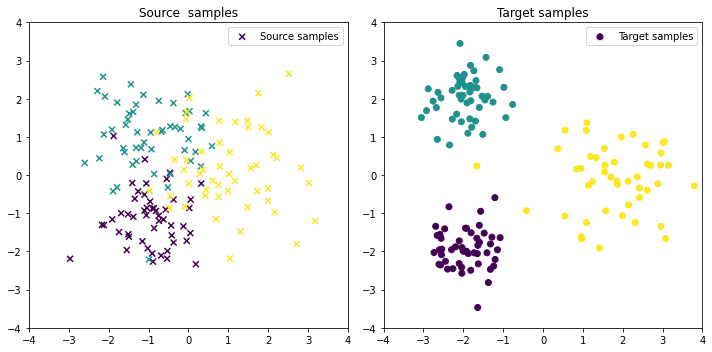

In [14]:
pl.figure(1, figsize=(10, 5))
pl.subplot(1, 2, 1)
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='x', label='Source samples')
# pl.xticks([])
# pl.yticks([])
pl.xlim(-4,4)
pl.ylim(-4,4)

pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(1, 2, 2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
# pl.xticks([])
# pl.yticks([])
pl.xlim(-4,4)
pl.ylim(-4,4)

pl.legend(loc=0)
pl.title('Target samples')
pl.tight_layout()

## Fig 2 : plot optimal couplings and transported samples



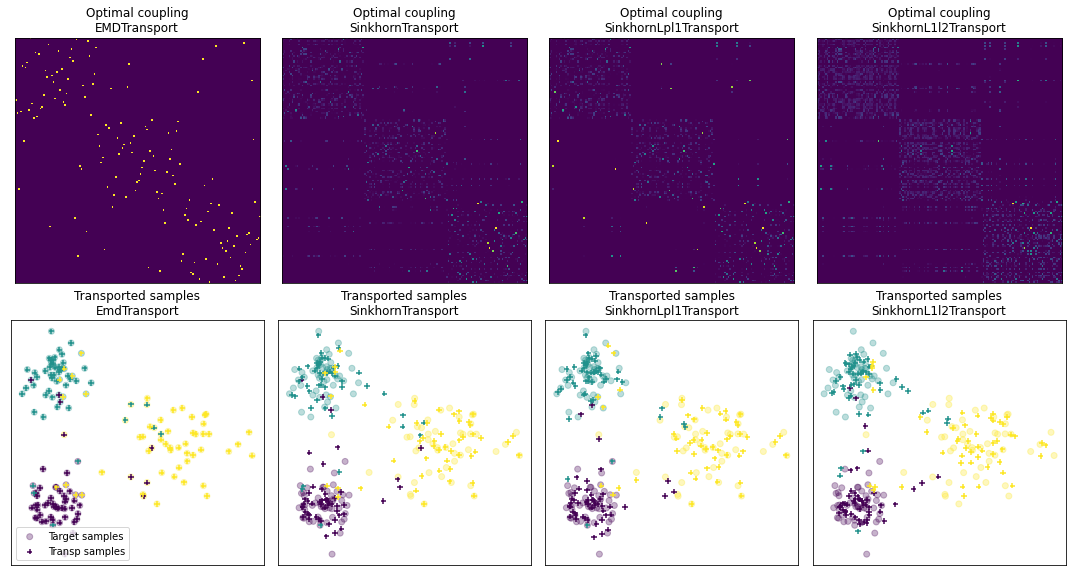

In [15]:
param_img = {'interpolation': 'nearest'}

pl.figure(2, figsize=(15, 8))
pl.subplot(2, 4, 1)
pl.imshow(ot_emd.coupling_, **param_img)
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nEMDTransport')

pl.subplot(2, 4, 2)
pl.imshow(ot_sinkhorn.coupling_, **param_img)
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornTransport')

pl.subplot(2, 4, 3)
pl.imshow(ot_lpl1.coupling_, **param_img)
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornLpl1Transport')

pl.subplot(2, 4, 4)
pl.imshow(ot_l1l2.coupling_, **param_img)
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornL1l2Transport')

pl.subplot(2, 4, 5)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.3)
pl.scatter(transp_Xs_emd[:, 0], transp_Xs_emd[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.xticks([])
pl.yticks([])
pl.title('Transported samples\nEmdTransport')
pl.legend(loc="lower left")

pl.subplot(2, 4, 6)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.3)
pl.scatter(transp_Xs_sinkhorn[:, 0], transp_Xs_sinkhorn[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.xticks([])
pl.yticks([])
pl.title('Transported samples\nSinkhornTransport')

pl.subplot(2, 4, 7)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.3)
pl.scatter(transp_Xs_lpl1[:, 0], transp_Xs_lpl1[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.xticks([])
pl.yticks([])
pl.title('Transported samples\nSinkhornLpl1Transport')

pl.subplot(2, 4, 8)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.3)
pl.scatter(transp_Xs_l1l2[:, 0], transp_Xs_l1l2[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.xticks([])
pl.yticks([])
pl.title('Transported samples\nSinkhornL1l2Transport')
pl.tight_layout()

pl.show()